<center>
<img src="./pict/folium_logo.png">
<br />
<br />

In [ ]:
!pip install folium # установка Folium, или так: !conda install folium -c conda-forge

In [1]:
import folium
import geopy # объединенное API для популярных гео-кодирующих сервисов
from geopy.geocoders import Yandex, GoogleV3

# https://developers.google.com/maps/documentation/geocoding/start - получить свой API Key

with open('./Google_API/api_key.txt', 'r') as f:  # считываем текстовый файл
    api_key = f.read()
    
geolocator_google = GoogleV3(api_key=api_key)

In [2]:
# https://mash.ru/letter/coronavirus-2/ - данные взяты отсюда

import pandas as pd

coronavirus_data = pd.read_excel('./data/coronavirus_cases.xlsx')
coronavirus_data.head()

,#,address,date
0,1,"3-й квартал Капотни, 3",28-30 марта
1,2,"4-й квартал Капотни, 9",28-30 марта
2,3,"Авиаторов,6, к1",28-30 марта
3,4,"Адмирала Лазарева, 38",28-30 марта
4,5,"Академика Комарова, 7а",28-30 марта


In [3]:
geolocator_google.geocode('Москва, Китай-город')

Location(Kitay-Gorod, Moscow, Russia, (55.7521239, 37.6211384, 0.0))

In [4]:
geolocator_google.geocode('Сбербанк, центральный офис')

Location(Kommunisticheskaya Ulitsa, 40, Volgograd, Volgogradskaya oblast', Russia, 400005, (48.71748299999999, 44.5268971, 0.0))

In [5]:
from tqdm import tqdm_notebook

lat = []
long = []
strange_address = []

for i in tqdm_notebook(range(coronavirus_data.shape[0])):
    
    address = 'Москва, ' + coronavirus_data.address.iloc[i]
    try:
        location = geolocator_google.geocode(address) # геокодирование
        lat.append(location.latitude)
        long.append(location.longitude)
        
    except:
        strange_address.append(address)
        lat.append('NaN')
        long.append('NaN')
        
coronavirus_data['lat'] = lat
coronavirus_data['long'] = long

coronavirus_data.to_csv('./data/coronavirus_cases.csv', index=False)

In [6]:
from folium.features import DivIcon

m = folium.Map(location=[55.755826, 37.6172999], # Москва
               zoom_start=10)

folium.Marker([55.7736765, 37.6054691], 
              tooltip='Сбербанк',
              icon=folium.Icon(color='green', icon=None)).add_to(m)

folium.Marker([55.752023, 37.6174994], 
              tooltip='Кремль',
              icon=folium.Icon(color='red', icon='star')).add_to(m)

folium.CircleMarker(location = [55.9297243, 37.5199434], 
                    radius = 50).add_to(m)

folium.PolyLine(locations = [(55.929724, 37.5199434), (55.752023, 37.6174994)], 
                line_opacity = 0.5).add_to(m)

folium.map.Marker(
    [55.755826, 37.6172999],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt; color:red"> Текст </div>',
        )
    ).add_to(m)


m

In [7]:
coronavirus_data = coronavirus_data.fillna('NaN')
coronavirus_data = coronavirus_data[(coronavirus_data.lat != 'NaN') & (coronavirus_data.long != 'NaN')]
colors = dict(zip(coronavirus_data.date.unique(), ['green', 'darkred', 'blue']))

In [8]:
m = folium.Map(location=[55.755826, 37.6172999], # Москва
               zoom_start=10)

folium.Marker([55.7736765, 37.6054691], 
              tooltip='Сбербанк',
              icon=folium.Icon(color='green', icon=None)).add_to(m)

folium.Marker([55.752023, 37.6174994], 
              tooltip='Кремль',
              icon=folium.Icon(color='red', icon='star')).add_to(m)

for i, row in coronavirus_data.iterrows():
    
    color = colors[row.date]
    folium.Marker([row.lat, row.long], 
                  tooltip=row.date,
                  icon=folium.Icon(color=color, icon='None'),
                  popup=folium.Popup('<b> Адрес: </b>' + '<br>' +
                                     row.address, 
                                     max_width=500)).add_to(m)

m

In [9]:
m.save('./data/coronavirus_cases_map.html') # конвертирование в html

In [10]:
from folium.plugins import HeatMap 

coronavirus_heatmap = coronavirus_data[['lat', 'long']].copy()
coronavirus_heatmap['weight'] = 1
coronavirus_heatmap = coronavirus_heatmap.values.tolist()

m = folium.Map(location=[55.755826, 37.6172999], tiles='stamentoner',
               zoom_start=10)

HeatMap(coronavirus_heatmap).add_to(m)

m

In [11]:
from folium.plugins import HeatMapWithTime

coronavirus_heatmap = coronavirus_data[['date', 'lat', 'long']].copy()
coronavirus_heatmap['weight'] = 1

coronavirus_heatmaptime = []
for dates in [['24 марта'], 
              ['24 марта', '25 марта-27 марта'], 
              ['24 марта', '25 марта-27 марта', '28-30 марта']]:
    coronavirus_heatmaptime.append(coronavirus_heatmap[coronavirus_heatmap.date.isin(dates)][['lat', 
                                                                         'long', 'weight']].values.tolist())
    
m = folium.Map(location=[55.755826, 37.6172999], 
               zoom_start=9)

HeatMapWithTime(coronavirus_heatmaptime).add_to(m)

m

In [ ]:
# Как найти полигоны?

# Заходим сюда: https://nominatim.openstreetmap.org/search.php?q=&polygon_geojson=1&viewbox=
# Ищем необходимый объект
# В описании объекта находим код OSM 
# Заходим сюда: http://polygons.openstreetmap.fr/index.py  
# Вбиваем код OSM
# Получаем GeoJSON 
# Profit! 

In [12]:
import json

with open('./data/moscow.json') as json_file:
    moscow_polygon = json.load(json_file)
    
with open('./data/new_moscow.json') as json_file:
    new_moscow_polygon = json.load(json_file)
    
with open('./data/tver_region.json') as json_file:
    tver_region_polygon = json.load(json_file)
    
m = folium.Map(location=[55.755826, 37.6172999], # Москва
               zoom_start=7)

m.choropleth(new_moscow_polygon, fill_color='yellow')
m.choropleth(moscow_polygon, fill_color='brown')
m.choropleth(tver_region_polygon, fill_color='blue')

folium.map.Marker(
    [55.755826, 37.6172999],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt; color:green"> Москва </div>',
        )
    ).add_to(m)

folium.map.Marker(
    [55.4903205, 37.3032108], # Троицк
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt; color:red"> Троицк </div>',
        )
    ).add_to(m)


folium.map.Marker(
    [56.85872140000001, 35.9175965], # Тверь
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 24pt; color:white"> Тверь </div>',
        )
    ).add_to(m)

m

/Users/aleksey_ryabykh/anaconda3/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


<center>
<img src="./pict/geopandas_logo.png">
<br />
<br />

In [14]:
import shapely # аналог numpy в мире гео
import geopandas as gpd # аналог pandas в мире гео

import pandas as pd # уже знакомые библиотеки
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
gpd.show_versions() # зависимости


SYSTEM INFO
-----------
python     : 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46)  [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
executable : /Users/aleksey_ryabykh/anaconda3/bin/python
machine    : Darwin-20.3.0-x86_64-i386-64bit

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : 3.7.1
GEOS lib   : /Users/aleksey_ryabykh/anaconda3/lib/libgeos_c.dylib
GDAL       : 2.4.4
GDAL data dir: /Users/aleksey_ryabykh/anaconda3/lib/python3.6/site-packages/fiona/gdal_data
PROJ       : 7.2.1
PROJ data dir: /Users/aleksey_ryabykh/anaconda3/lib/python3.6/site-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.9.0
pandas     : 1.1.5
fiona      : 1.8.18
numpy      : 1.19.5
shapely    : 1.7.1
rtree      : 0.9.7
pyproj     : 3.0.1
matplotlib : 3.3.4
mapclassify: 2.4.2
geopy      : 2.1.0
psycopg2   : 2.7.6.1 (dt dec pq3 ext lo64)
geoalchemy2: 0.8.5
pyarrow    : 3.0.0
pygeos     : 0.9


In [ ]:
!pip install geopandas # установка geopandas, или так: !conda install --channel conda-forge geopandas

Базовые объекты в __GeoPandas__

In [16]:
from shapely.geometry import Polygon, Point, LineString

p1 = Polygon([(0, 0), (1, 0), (1, 1)]) # Polygons / Multi-Polygons
p2 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p3 = Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])
p4 = Point(0.5, 0.5) # Points / Multi-Points
p5 = Point(2.5, 0.5)
p6 = LineString([[1, 1], [2, 0]]) # Lines / Multi-Lines
p7 = LineString([[2, 1], [1, 0]])

gs = gpd.GeoSeries([p2, p1, p3, p4, p5, p6, p7]) # GeoSeries

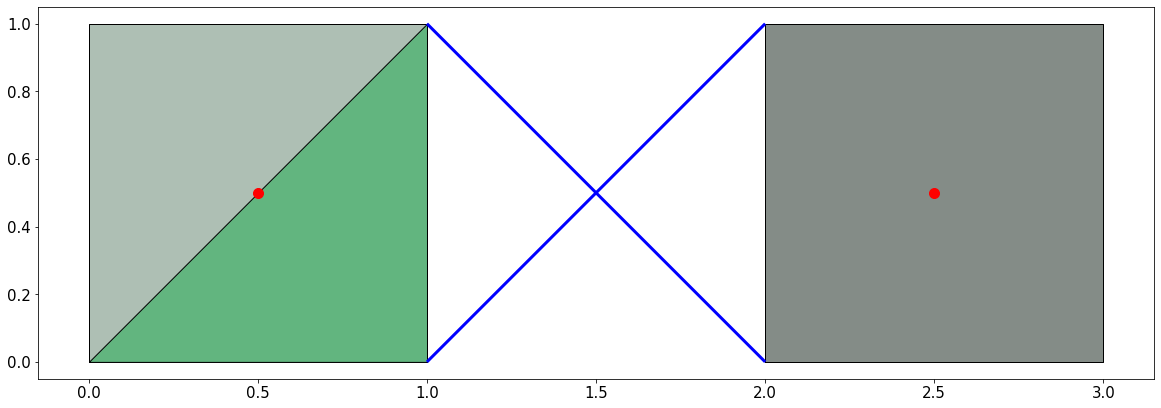

In [17]:
fig = plt.figure(figsize=(20, 10))
ax = plt.gca()

gs[:1].plot(ax=ax, facecolor='#aebfb4', edgecolor='black')
gs[1:2].plot(ax=ax, facecolor='#62b57f', edgecolor='black')
gs[2:3].plot(ax=ax, facecolor='#848c87', edgecolor='black')
gs[3:5].plot(ax=ax, facecolor='red', markersize=100)
gs[5:].plot(ax=ax, color='blue', linewidth=3)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 

In [18]:
gs.area # площади фигур

0    1.0
1    0.5
2    1.0
3    0.0
4    0.0
5    0.0
6    0.0
dtype: float64

In [19]:
gs.bounds # максимум и минимум для каждой оси каждой фигуры

,minx,miny,maxx,maxy
0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,1.0
2,2.0,0.0,3.0,1.0
3,0.5,0.5,0.5,0.5
4,2.5,0.5,2.5,0.5
5,1.0,0.0,2.0,1.0
6,1.0,0.0,2.0,1.0


In [20]:
gs.total_bounds  # то же самое только для всей GeoSeries в целом

array([0., 0., 3., 1.])

In [21]:
gs.boundary # границы фигур (низкоразмерное представление фигуры), для точки границ нет

0    LINESTRING (0.00000 0.00000, 1.00000 0.00000, ...
1    LINESTRING (0.00000 0.00000, 1.00000 0.00000, ...
2    LINESTRING (2.00000 0.00000, 3.00000 0.00000, ...
3                             GEOMETRYCOLLECTION EMPTY
4                             GEOMETRYCOLLECTION EMPTY
5        MULTIPOINT (1.00000 1.00000, 2.00000 0.00000)
6        MULTIPOINT (2.00000 1.00000, 1.00000 0.00000)
dtype: geometry

In [22]:
gs.centroid # центроиды фигур

0    POINT (0.50000 0.50000)
1    POINT (0.66667 0.33333)
2    POINT (2.50000 0.50000)
3    POINT (0.50000 0.50000)
4    POINT (2.50000 0.50000)
5    POINT (1.50000 0.50000)
6    POINT (1.50000 0.50000)
dtype: geometry

In [23]:
gs.representative_point() # точки, которые гарантировано находятся внутри фигуры (необязательно центроиды)

0    POINT (0.50000 0.50000)
1    POINT (0.75000 0.50000)
2    POINT (2.50000 0.50000)
3    POINT (0.50000 0.50000)
4    POINT (2.50000 0.50000)
5    POINT (1.00000 1.00000)
6    POINT (2.00000 1.00000)
dtype: geometry

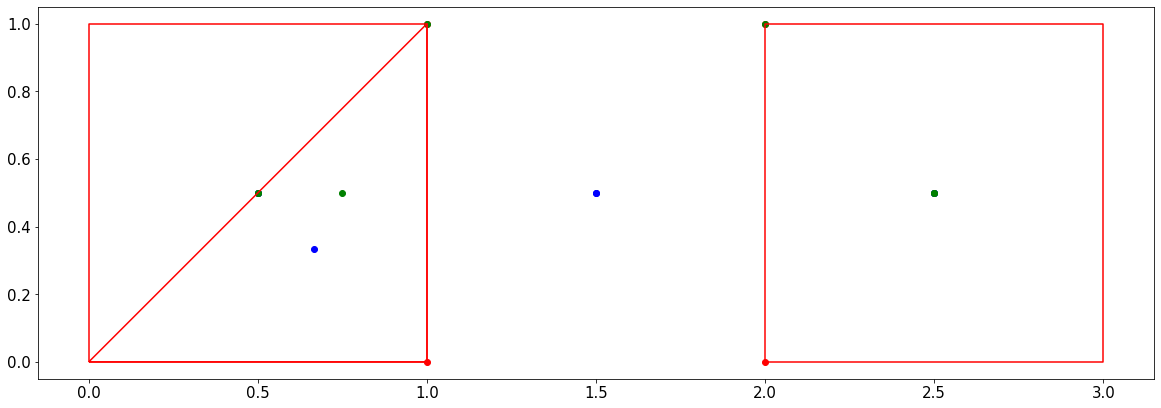

In [24]:
fig = plt.figure(figsize=(20, 10)) # границы, центроиды и представляющие точки для GeoSeries выше
ax = plt.gca()

gs.boundary.plot(ax=ax, color='red')
gs.centroid.plot(ax=ax, color='blue')
gs.representative_point().plot(ax=ax, color='green')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 

In [25]:
gs.convex_hull # возвращает минимальную выпуклую фигуру, содержающую изначальную. Для двух точек - линия, 
                # для точки - точка

0    POLYGON ((0.00000 0.00000, 0.00000 1.00000, 1....
1    POLYGON ((0.00000 0.00000, 1.00000 1.00000, 1....
2    POLYGON ((2.00000 0.00000, 2.00000 1.00000, 3....
3                              POINT (0.50000 0.50000)
4                              POINT (2.50000 0.50000)
5        LINESTRING (1.00000 1.00000, 2.00000 0.00000)
6        LINESTRING (2.00000 1.00000, 1.00000 0.00000)
dtype: geometry

In [26]:
gs.envelope # минимальный прямоугольный полигон (стороны параллельны осям), содержащий каждую из исходных фигур

0    POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....
1    POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....
2    POLYGON ((2.00000 0.00000, 3.00000 0.00000, 3....
3                              POINT (0.50000 0.50000)
4                              POINT (2.50000 0.50000)
5    POLYGON ((1.00000 0.00000, 2.00000 0.00000, 2....
6    POLYGON ((1.00000 0.00000, 2.00000 0.00000, 2....
dtype: geometry

In [27]:
gs.buffer(0.1) # возвращает все точки находящиеся на расстояние r от фигуры

0    POLYGON ((-0.10000 0.00000, -0.10000 1.00000, ...
1    POLYGON ((-0.07071 0.07071, 0.92929 1.07071, 0...
2    POLYGON ((1.90000 0.00000, 1.90000 1.00000, 1....
3    POLYGON ((0.60000 0.50000, 0.59952 0.49020, 0....
4    POLYGON ((2.60000 0.50000, 2.59952 0.49020, 2....
5    POLYGON ((2.07071 0.07071, 2.07730 0.06344, 2....
6    POLYGON ((1.07071 -0.07071, 1.06344 -0.07730, ...
dtype: geometry

In [28]:
gs.simplify(tolerance=0.05) # возвращает упрощенное представление фигуры

0    POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....
1    POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....
2    POLYGON ((2.00000 0.00000, 3.00000 0.00000, 3....
3                              POINT (0.50000 0.50000)
4                              POINT (2.50000 0.50000)
5        LINESTRING (1.00000 1.00000, 2.00000 0.00000)
6        LINESTRING (2.00000 1.00000, 1.00000 0.00000)
dtype: geometry

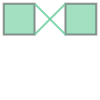

In [29]:
gs.unary_union # объединение всех фигур в GeoSeries

In [30]:
type(gs.unary_union) # GeometryCollection

shapely.geometry.collection.GeometryCollection

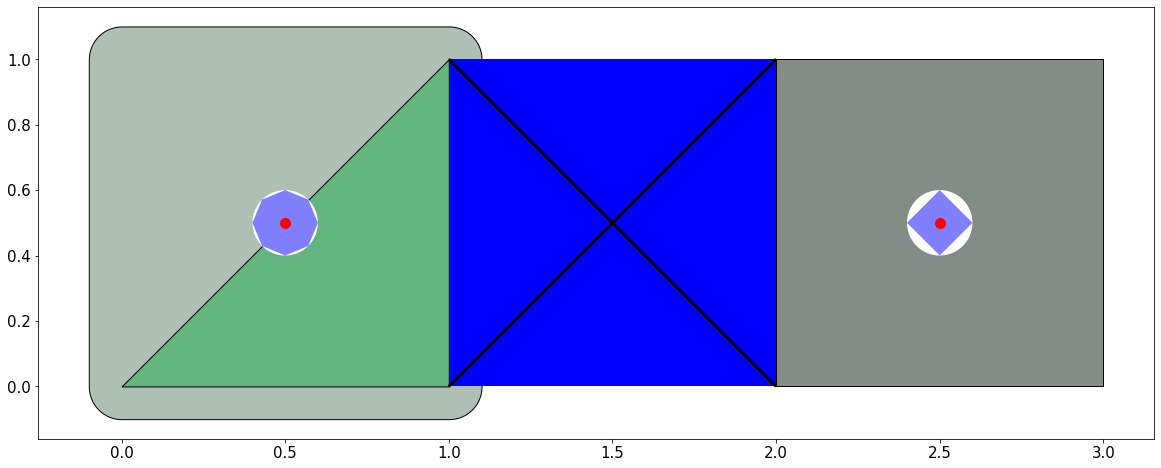

In [31]:
fig = plt.figure(figsize=(20, 10))
ax = plt.gca()

gs[:1].buffer(0.1).plot(ax=ax, facecolor='#aebfb4', edgecolor='black')
gs[1:2].plot(ax=ax, facecolor='#62b57f', edgecolor='black')
gs[2:3].plot(ax=ax, facecolor='#848c87', edgecolor='black')

gs[3:5].buffer(0.1).plot(ax=ax, facecolor='white', markersize=100)
gs[3:4].buffer(0.1).simplify(tolerance=0.01).plot(ax=ax, color='blue', alpha=0.5)
gs[4:5].buffer(0.1).simplify(tolerance=0.1).plot(ax=ax, color='blue', alpha=0.5)
gs[3:5].plot(ax=ax, facecolor='red', markersize=100)

gs[5:].envelope.plot(ax=ax, color='blue', linewidth=3)
gs[5:].plot(ax=ax, color='black', linewidth=3)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 

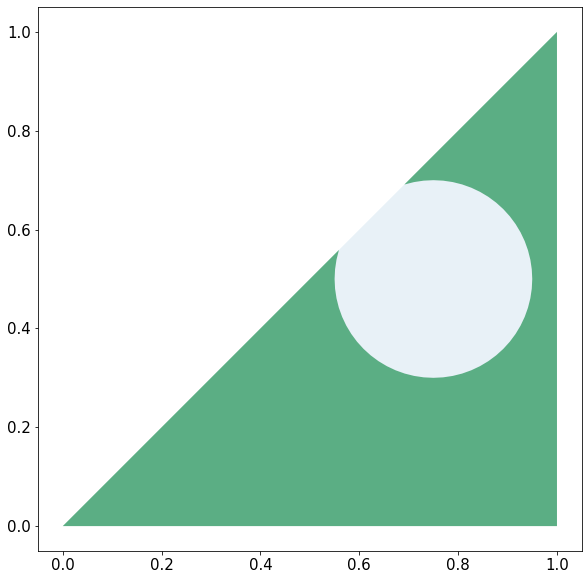

In [32]:
fig = plt.figure(figsize=(20, 10))
ax = plt.gca()

triangle = gs[1:2].values[0]
circle = gs[1:2].representative_point().buffer(0.2).values[0]

diff = gpd.GeoSeries([triangle - circle])
diff.plot(ax=ax, color='#62b57f')
diff.convex_hull.plot(ax=ax, alpha=0.1)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 

In [33]:
diff.geom_almost_equals(triangle) # проверка на "почти" равенство

0    False
dtype: bool

In [34]:
diff.intersects(triangle) # проверка на пересечение с фигурой

0    True
dtype: bool

In [35]:
diff.contains(triangle) # проверка на вхождени

0    False
dtype: bool

In [36]:
gpd.GeoSeries([triangle]).contains(diff)

0    True
dtype: bool

In [37]:
type(diff.values[0])

shapely.geometry.polygon.Polygon

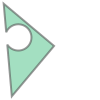

In [38]:
shapely.affinity.rotate(diff.values[0], 50) # вращение фигуры

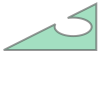

In [39]:
shapely.affinity.scale(diff.values[0], xfact=10, yfact=5.0) # масштабирование фигуры

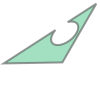

In [40]:
shapely.affinity.skew(diff.values[0], xs=30, ys=1) # наклоны

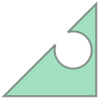

In [41]:
shapely.affinity.translate(diff.values[0], xoff=3.0, yoff=5.0, zoff=0.0)

<AxesSubplot:>

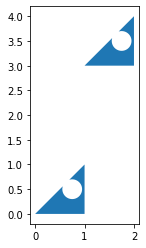

In [42]:
gpd.GeoSeries([diff.values[0], # сдвиги по осям
               shapely.affinity.translate(diff.values[0], xoff=1.0, yoff=3.0, zoff=0.0)]).plot()

In [ ]:
# еще больше вариантов преобразований
# https://shapely.readthedocs.io/en/stable/manual.html#affine-transformations

Составные объекты в __GeoPandas__

<AxesSubplot:>

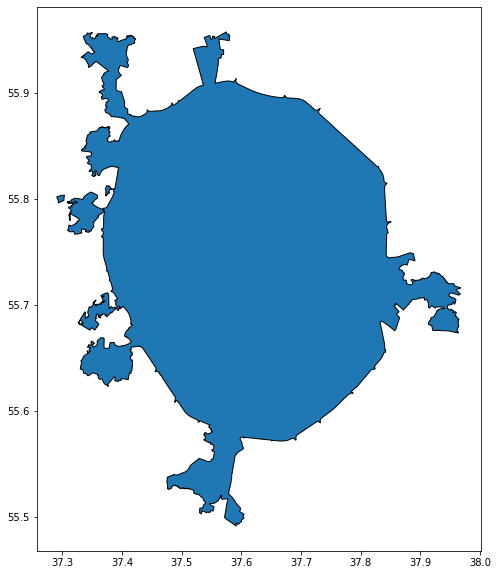

In [43]:
# считывание гео-данных 

moscow_from_link = gpd.read_file('http://polygons.openstreetmap.fr/get_geojson.py?id=2555133&params=0')
moscow_from_link['geometry'] = moscow_from_link['geometry'].apply(lambda x: x[0])
moscow_from_link.plot(edgecolor='black', figsize=(10, 10))

In [44]:
# из файла json
moscow_from_json = gpd.read_file('./data/moscow.json')
moscow_from_json['geometry'] = moscow_from_json['geometry'].apply(lambda x: x[0])

# запись в geojson
# moscow_from_json.to_file("moscow_from_json.geojson", driver='GeoJSON')

<AxesSubplot:>

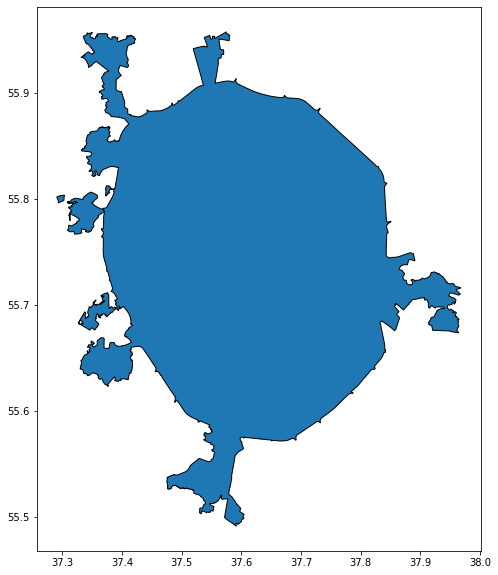

In [45]:
moscow_from_json.plot(edgecolor='black', figsize=(10, 10))

In [46]:
moscow_from_json['name'] = 'Москва'
moscow_from_json # обязательный атрибут GeoDataFrame - поле geometry

,geometry,name
0,"MULTIPOLYGON (((37.29822 55.79763, 37.29447 55...",Москва


In [47]:
type(moscow_from_json) # GeoDataFrame

geopandas.geodataframe.GeoDataFrame

In [48]:
moscow_from_json.crs # проекция, их очень много и разных - https://en.wikipedia.org/wiki/Map_projection

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

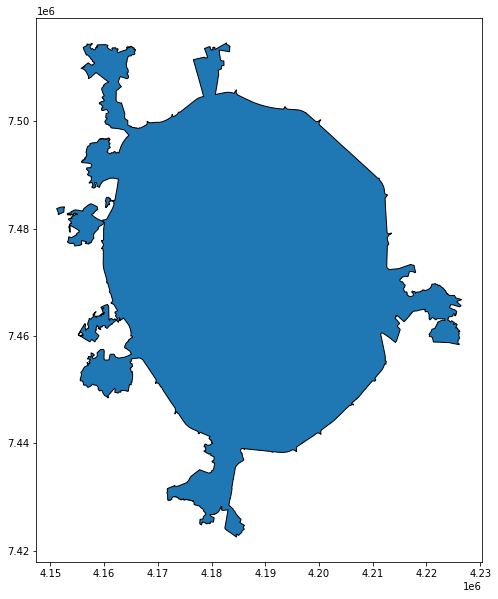

In [49]:
# преобразование проекций, 3395 - проекция меркатора, обратите внимание на оси
moscow_from_json.to_crs(epsg=3395).plot(edgecolor='black', figsize=(10, 10))

In [50]:
coronavirus_cases = pd.read_csv('./data/coronavirus_cases.csv')
coronavirus_cases = coronavirus_cases.dropna()
coronavirus_cases.head()

,#,address,date,lat,long
0,1,"3-й квартал Капотни, 3",28-30 марта,55.635714,37.802126
1,2,"4-й квартал Капотни, 9",28-30 марта,55.636395,37.792573
2,3,"Авиаторов,6, к1",28-30 марта,55.647897,37.394463
3,4,"Адмирала Лазарева, 38",28-30 марта,55.545078,37.524365
4,5,"Академика Комарова, 7а",28-30 марта,55.828914,37.592907


In [51]:
geometry = []
for _, row in coronavirus_cases.iterrows():
    geometry.append(Point(row.long, row.lat))
    
coronavirus_cases['geometry'] = geometry # обязательный столбец geometry
coronavirus_cases = gpd.GeoDataFrame(coronavirus_cases)
coronavirus_cases.head()

,#,address,date,lat,long,geometry
0,1,"3-й квартал Капотни, 3",28-30 марта,55.635714,37.802126,POINT (37.80213 55.63571)
1,2,"4-й квартал Капотни, 9",28-30 марта,55.636395,37.792573,POINT (37.79257 55.63639)
2,3,"Авиаторов,6, к1",28-30 марта,55.647897,37.394463,POINT (37.39446 55.64790)
3,4,"Адмирала Лазарева, 38",28-30 марта,55.545078,37.524365,POINT (37.52437 55.54508)
4,5,"Академика Комарова, 7а",28-30 марта,55.828914,37.592907,POINT (37.59291 55.82891)


<AxesSubplot:>

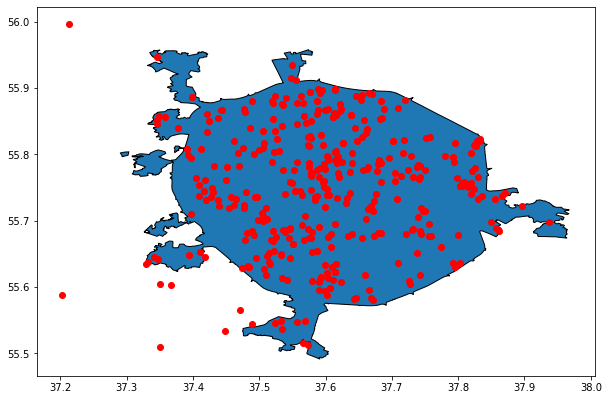

In [52]:
ax = moscow_from_json.plot(edgecolor='black', figsize=(10, 10))
coronavirus_cases.plot(ax=ax, color='red')

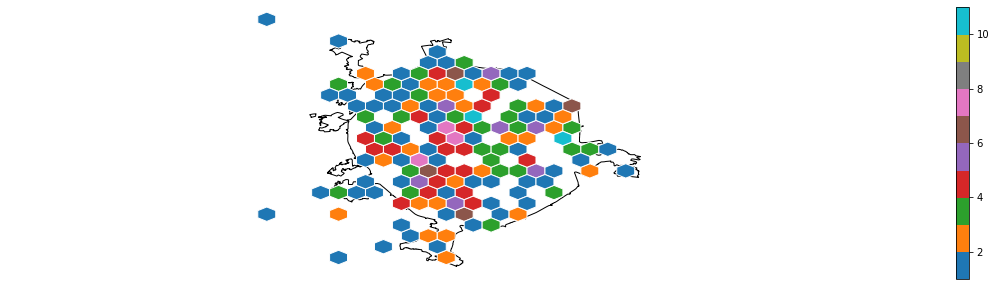

/Users/aleksey_ryabykh/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


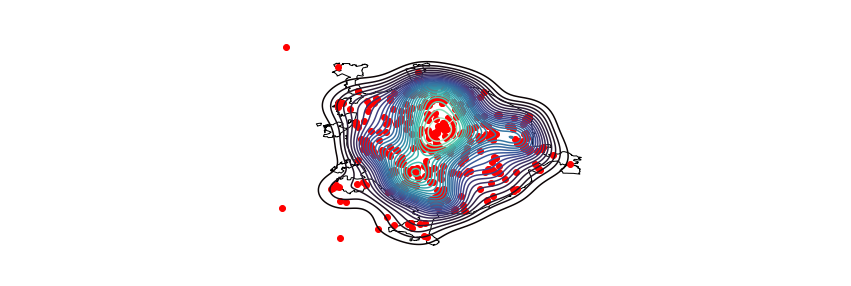

In [55]:
import seaborn as sns

f, ax = plt.subplots(1, figsize=(20, 5)) # гексагональная биннаризация
moscow_from_link.plot(ax=ax, facecolor='white', edgecolor='black')
hb = ax.hexbin(coronavirus_cases['geometry'].x, coronavirus_cases['geometry'].y, 
               gridsize=20, mincnt=1, edgecolor='white', cmap='tab10')
ax.set_axis_off()
plt.colorbar(hb)
plt.axis('equal')
plt.show()

f, ax = plt.subplots(1, figsize=(15, 5)) # Kernel Density Estimation
moscow_from_link.plot(ax=ax, facecolor='white', edgecolor='black')
sns.kdeplot(coronavirus_cases['geometry'].x, coronavirus_cases['geometry'].y, n_levels=30, cmap='mako')
coronavirus_cases.plot(ax=ax, color='red')
ax.set_axis_off()
plt.axis('equal')
plt.show()

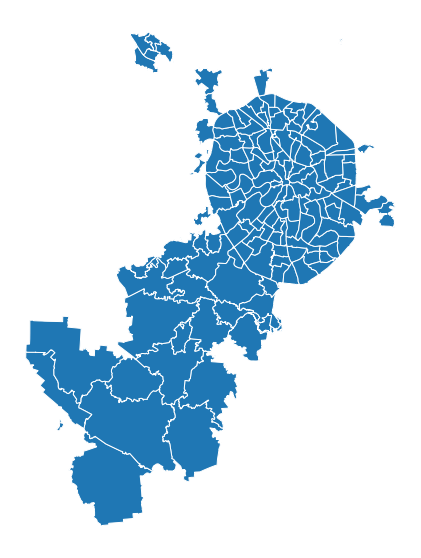

In [56]:
# чтение из shape файла, чаще всего основной формат для гео-задач
big_moscow = gpd.read_file('./data/big_moscow/big_moscow.shp')
big_moscow_districts = gpd.read_file('./data/big_moscow_disticts/big_moscow_districts.shp')

# запись в shape файл
# big_moscow.to_file(driver='ESRI Shapefile', filename="./data/big_moscow.shp")

ax = big_moscow_districts.plot(figsize=(20, 10), edgecolor='white')
ax.set_axis_off()

<AxesSubplot:>

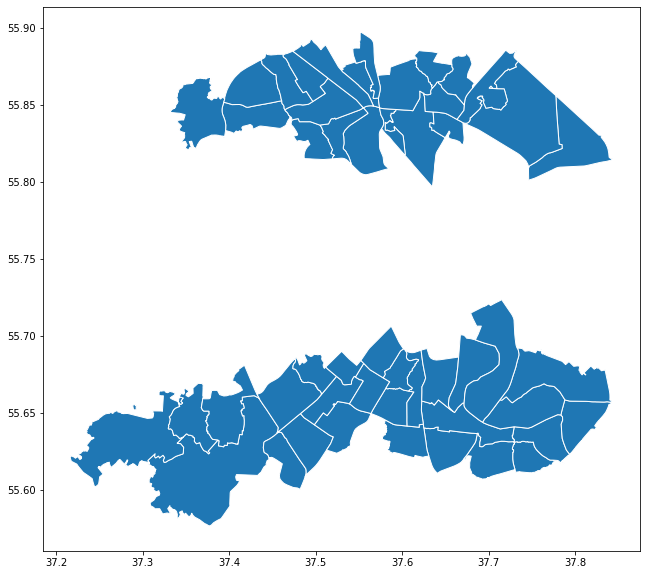

In [57]:
big_moscow_districts.iloc[50:100].plot(figsize=(20, 10), edgecolor='white') # индексирование аналогичное Pandas

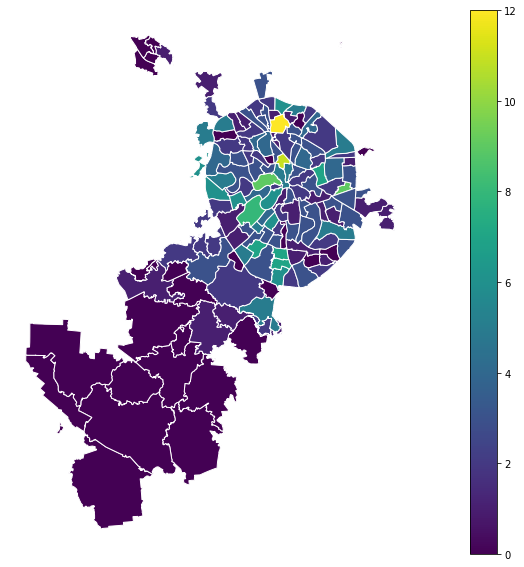

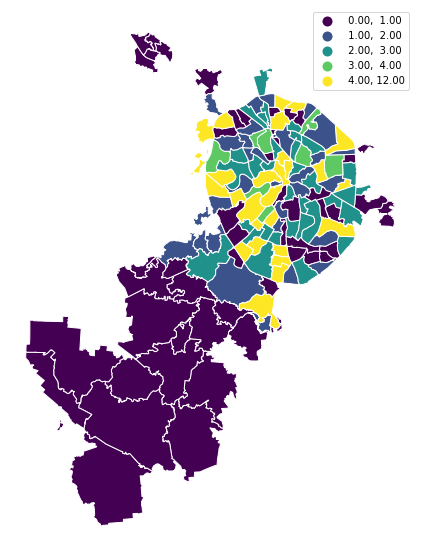

In [58]:
big_moscow_districts['coronavirus_cases'] = big_moscow_districts['geometry']\
                .apply(lambda x: sum([point.within(x) for point in coronavirus_cases.geometry])) # within

ax = big_moscow_districts.plot(column='coronavirus_cases', figsize=(20, 10), cmap='viridis',
                               edgecolor='white', legend=True)
ax.set_axis_off()

ax = big_moscow_districts.plot(column='coronavirus_cases', figsize=(20, 10), cmap='viridis',
                               scheme='quantiles', # equal_interval
                               edgecolor='white', legend=True) # pySAL
ax.set_axis_off()

In [59]:
buffer_cases = gpd.GeoDataFrame(coronavirus_cases.geometry.buffer(0.01), columns=['geometry'])

/Users/aleksey_ryabykh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  """Entry point for launching an IPython kernel.


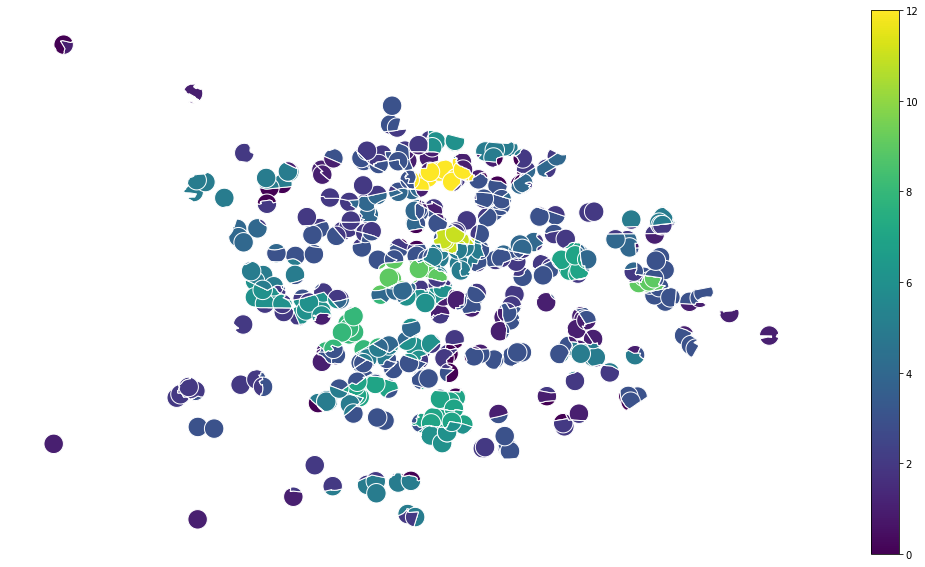

In [61]:
overlay = gpd.overlay(buffer_cases, big_moscow_districts) # overlay 

ax = overlay.plot(column='coronavirus_cases', figsize=(20, 10), cmap='viridis',
                               edgecolor='white', legend=True)
ax.set_axis_off() 

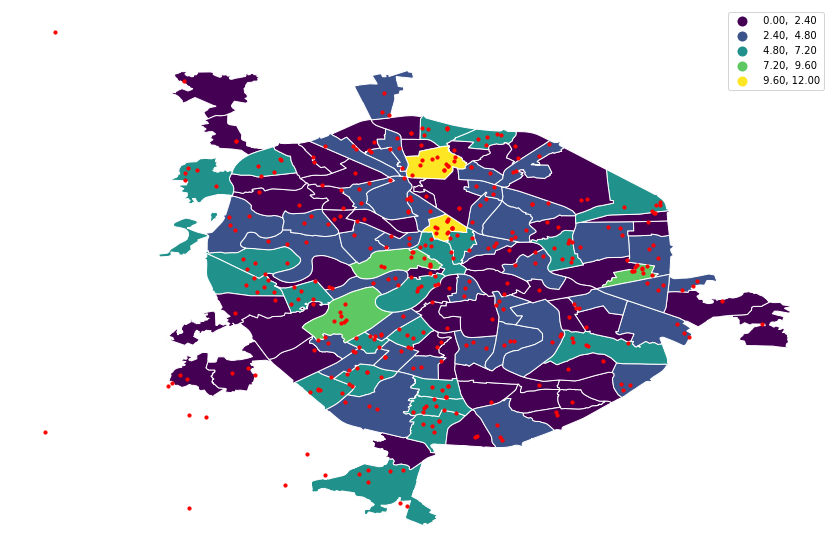

In [62]:
small_moscow_districts = gpd.overlay(moscow_from_json, big_moscow_districts) # overlay
ax = small_moscow_districts.plot(column='coronavirus_cases', figsize=(20, 10), cmap='viridis',
                               scheme='equal_interval',
                               edgecolor='white', legend=True)
coronavirus_cases.plot(ax=ax, color='red', markersize=10)
ax.set_axis_off()

In [63]:
small_moscow_districts['name'] = 'Москва'
spatial_join = gpd.sjoin(big_moscow_districts, small_moscow_districts, op='within', how='left') 
spatial_join.name = spatial_join.name.fillna('Новая Москва') # пространственный join

In [64]:
spatial_join.dissolve(by='name', aggfunc='sum') # пространственная агрегация

,geometry,FID_left,coronavirus_cases_left,index_right,FID_right,coronavirus_cases_right
name,,,,,,
Москва,"POLYGON ((37.43448 55.80882, 37.43235 55.80881...",5011,247,4545.0,5011.0,247.0
Новая Москва,"MULTIPOLYGON (((36.91347 55.31718, 36.91201 55...",5574,133,0.0,0.0,0.0
